# From Linear Regression to Neural Networks

**Level:** Coding from scratch. As low as we're getting. Then transitioning to using a library.

**Goals:** The take-aways from this notebook are:
1. Understand what *activation functions* do and why they are necessary.
1. Implement a network with layers as the next step after line fits.
2. Use the PyTorch and fastai libraries to implement neural networks.

**Sources:** These notes continue to be based on [this notebook](https://www.kaggle.com/code/jhoward/how-does-a-neural-net-really-work) and [Chapter 4 of the Fastai](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb) book.

## Sections in this Notebook

* [A Linear Regression Model](#scrollTo=urCQPMZzmWBe)
* [Activation Functions](#scrollTo=kLRUizjlKkdR)
* [Adding a Layer](#scrollTo=YHFsufMbhk44)
* [Adding N Layers](#scrollTo=_vpwf1fIou9l)
* [The fast.ai Tabular Learner](#scrollTo=JFXgg4g1uBY_)


## Vocab Terms:

* **Adam.** A type of gradient descent algorithm that refines our simply subtracting `lr*w.grad` from each weight by adding in two techniques called "momentum" and "RMSprop".

* **activation function.** A function used between layers of a neural network. These functions are always non-linear so that they can reproduce a general function.

* **deep learning.** Using a neural network with many layers to do machine learning.

* **hidden layer.** Intermediate layers of a neural network. They're called "hidden" because the outputs of this layer aren't directly seen by the user, but are instead fed into the next layer.

* **neural network.** A series of interconnected layers of neurons.

* **neuron.** A single node in a neural network, that involves some input and an output activation.

* **output layer.** The last layer of a neural network, which produces outputs or $\hat{y}$ values. This layer tends to contain a linear (for regression), sigmoid (for binary classifiers), or softmax (for multiple category classifiers)

* **ReLU.** What is now the standard activation function. Stands for Rectified Linear Unit. It's just the line $y = x$, except it's 0 when $x < 0$.


In [ ]:
from ipywidgets import interact
from fastai.basics import *
import torch
from fastai.tabular.all import *

# Now we don't need to use plt.show()
%matplotlib inline

# Makes the figure output a bit smaller
plt.rc('figure', dpi=90)

# A helper function to plot generic functions
def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None, xlab=None, ylab=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim is not None: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)
    if xlab is not None: plt.xlabel(xlab)
    if ylab is not None: plt.ylabel(ylab)
    plt.show()

## A Linear Regression Model

Let's take what we've learned so far and apply it to a real dataset. This is an insurance claims dataset that I cannot track down he origin of. It seems to be a dataset that a lot of people are passing around. If you find the original source, let me know.

Our goal is going to be to predict how much money each person in the dataset ultimately costs the insurance agency over the course of a year. This is the "charges" column.



In [ ]:
insurance = pd.read_csv("https://raw.githubusercontent.com/Greg-Hallenbeck/class-datasets/main/datasets/insurance.csv")

insurance.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


This seems straightforward enough, although there is already a problem: three of the columns are categorical, and not numbers. We can use the `pd.get_dummies` function from the Pandas library to one-hot encode these columns:

In [ ]:
insurance = pd.get_dummies(insurance)
insurance.head(3)

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.90,0,16884.9240,True,False,False,True,False,False,False,True
1,18,33.77,1,1725.5523,False,True,True,False,False,False,True,False
2,28,33.00,3,4449.4620,False,True,True,False,False,False,True,False


In addition, it is common to normalize the variables to make their range be \[0, 1\]. This is done to make each variable of equal in scale, so that we don't have to take larger or smaller steps with certain parameters of the model.

In [ ]:
norm_insurance = insurance
norm_insurance = insurance/insurance.max()
norm_insurance.head(3)

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,0.296875,0.525127,0.0,0.264777,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.28125,0.635611,0.2,0.027059,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.4375,0.621118,0.6,0.069773,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


We also need to define what the predict function will do. We'll be using a line, so:

$\hat{y} = b + w_1 x_1 + w_2 x_2 + \cdots$

Since each $x$ is now multiple values (11 in all, one for each column of the dataframe), there will be 11 $w$ values as well. Each will be a tensor, and we can write $y$ as:

`y = b + (w * x).sum(axis=1)`

*Note:* axis 0 is summing over each column in the tensor, that is, we'd be combining different observations together. We want to keep each observation separate but sum up each different $x$ column within one observation. I figured out which axis to use by trial and error.

In [ ]:
def tensor_linear(w,b, x):
    return b + (w * x).sum(axis=1)

def loss(y, yhat):
    return (y-yhat).pow(2).mean()

In [ ]:
torch.manual_seed(42)

# Get the data
xs = torch.tensor(norm_insurance.loc[:, norm_insurance.columns != "charges"].values.astype(np.float32))
ys = torch.tensor(norm_insurance["charges"].values.astype(np.float32))

dataset = list(zip(xs,ys))
dl = DataLoader(dataset, batch_size=100, shuffle=True)

# Initialize parameters
w = torch.rand(len(insurance.columns)-1).requires_grad_()
b = torch.rand(1).requires_grad_()

num_epochs = 30
lr = 3e-2

# Keep track of the losses
losses = []

for e in range(num_epochs):
    losses.append(0)

    # New loop over each observation
    for step, (x,y) in enumerate(dl):

        # Calculate the predicted value
        yhat = tensor_linear(w, b, x)

        # Calculate approximate Loss
        J = loss(y, yhat)
        losses[-1] += float(J/len(dl))

        J.backward()
        with torch.no_grad():
            w.sub_(lr*w.grad)
            b.sub_(lr*b.grad)

        w.grad.data.zero_()
        b.grad.data.zero_()

In [ ]:
w.detach_()
b.detach_()

yhat = tensor_linear(w, b, xs)
J = loss(ys, yhat)

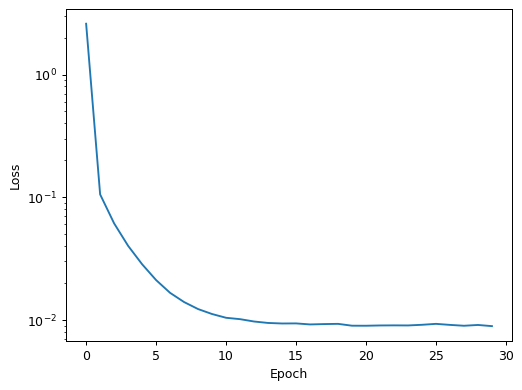

In [ ]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

We have a nicely-decreasing loss function. Now that we have *real* data, let's take a moment to talk about how we assess a model on real data. The *loss* is not a human-comprehensible measure. If you tell me the loss in a model is 1.5 or 20.2, I have no idea what that means. The loss was something we made up purely to help the machine fit the data.

What we're interested in is the standard deviation of the residuals (sometimes called the residual mean standard error, or rmse). A residual is an error on a prediction, that is, $y-\hat{y}$ for a particular observation. So taking the standard deviation gives the typical size of an error on each prediction. This *should be* something human-intelligible. In our current model, we normalized the costs to be 0-1, so a residual of 0.1 means 10% of the total range, or about $6000.

In [ ]:
print(torch.std(ys-yhat))

tensor(0.0951)


Looking more deeply, we can make a residual plot, which shows trends in the residuals as our predicted value changes. Ideally, residuals should be a horizontal line centered at an error of 0, with some scatter. We don't expect a perfect fit to every point. [Here's an example](https://statsnotebook.io/blog/analysis/linearity_homoscedasticity/).

Our residuals definitely *don't* look like that. There is some structure our model fails to capture, some non-linearity we need to account for.


Text(0, 0.5, 'Residual (Error)')

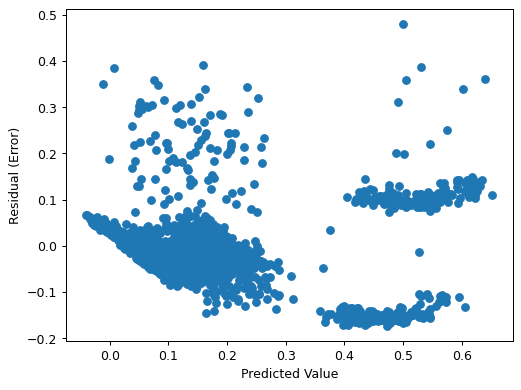

In [ ]:
plt.scatter(yhat, ys-yhat)
plt.xlabel("Predicted Value")
plt.ylabel("Residual (Error)")


## Activation Functions: Making Our Function Non-Linear

It's clear from the residuals above that a linear model isn't the best. But what kind of model? Previously, we used a quadratic, but is that the best one here? I honestly have no idea. What we're going to do is add together different functions (which will be our **activation functions**) with different weights and then, of course, use machine learning to figure out how to best do that.

It is important that we pick an activation function that isn't linear. If you take two lines:

$$ y = b_1 + m_1 x$$
$$ y = b_2 + m_2 x$$

Then add them together, you can group the terms like this:

$$ y = (b_1 + b_2) + (m_1 + m_2) x$$

And then defining $b' = b_1 + b_2$ and $m' = m_1 + m_2$, we just get one line:

$$ y = b' + m'x$$

Linear has a broader meaning than "line" here, although lines are linear (and pedants will note I actually mean "affine"). In this context, linear means that if you add two of them together, you get a new function just like the old ones, but with new weights. This means quadratics are linear.

Instead, we'll use the ReLU function, which has this form:

$$ y=   \left\{ \begin{array}{ll} 0 & x<0 \\ x & x\geq0 \\ \end{array} \right.  $$

Which we can write in code as simply:

```
if (x>0):
    return x
else:
    return 0
```
Which can be further simplified and sped up using PyTorch's `where` function:

In [ ]:
def relu(x):
    return torch.where(x>0, x, 0)

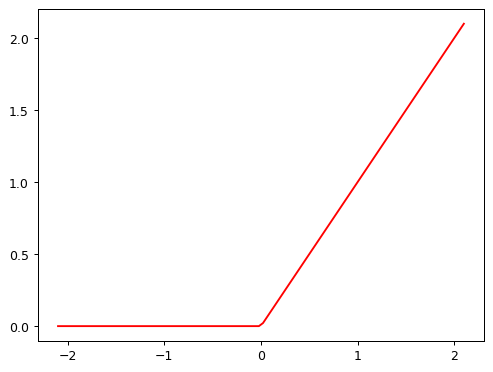

In [ ]:
plot_function(relu)

With some shifting back and forth, scaling, and mirroring, we can use just two these to do a decent fit to the quadratic we were previously working with. It has been proven that with enough ReLUs you can approximate *any* function.

(I found the best value for the weights using the same methods we always have.)

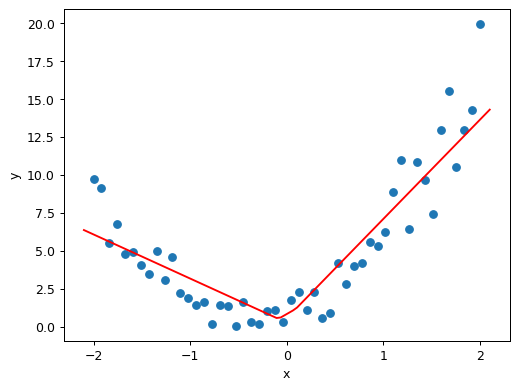

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/Greg-Hallenbeck/class-datasets/main/datasets/ml_sampledata.csv")
x_quad = data["x"]
y_quad = data["y"]

def double_relu(w,x):
    m1,b1,m2,b2 = w
    return relu(m1*x+b1) + relu(m2*x+b2)

w = tensor([-2.9069, 0.2689,  6.5412, 0.5728])

plt.scatter(x_quad,y_quad)
plot_function(partial(double_relu, w), xlab="x", ylab="y")

## Adding a Layer

How do we accomplish this scaling and mirroring? Take a look at the definition of the `double_relu()` function above: the input to each ReLU is a line. So, for each ReLU, we'll need a linear fit. Our model is going to look like this:

Let $R$ be the number of ReLUs we want and $M$ be the number of $x$ columns in our dataset.

* Generate a *lot* of lines, one for each ReLU we want. Now, instead of one single value of $b$, there are $R$ $b$s, one for each ReLU. There were already $M$ weights, one for each column, but now there is a matrix of weights that is $M\times R$ in size. The line outputs we'll call $a_1 \cdots a_R$. A is for "activation."
* Pass each of those $a$s through relus: $$z_r = ReLU(a_r)$$
* Take *these* outputs, and then combine them like a line to get our final output. We need $R$ weights for this list, not $M$:
$$\hat{y} = b'_1 + w'_1 z_1 + w'_2 z_2 + \cdots + w'_R z_R$$

It's actually reasonably simple in code:


In [ ]:
def tensor_linear(w,b, x):
    # Previously, x was a matrix and w was a vector, so what we had worked
    # But now, they are both matrices, so we use matrix multiplication
    return b + x @ w
    #return b + torch.matmul(x, w)

def relu(x):
    return torch.where(x>0, x, 0)

def one_layer(w1, b1, w2, b2, x):

    # Pass data through the "layers" one at a time
    a = tensor_linear(w1, b1, x)
    z = relu(a)
    yhat = tensor_linear(w2, b2, z)

    return yhat

This combination of a whole bunch of line fits followed by an activation function (in this case, a ReLU) is called a **hidden layer** of the model, while the layer that produces $\hat{y}$ is called the **output layer**. The hidden layer is called this because its outputs are "hidden", that is, we don't see anything that comes out of them directly. We just see the output of the output layer (very aptly named).


In [ ]:
# Set a seed for reproducible results
torch.manual_seed(42)

# Get the data
xs = torch.tensor(norm_insurance.loc[:, norm_insurance.columns != "charges"].values.astype(np.float32))
ys = torch.tensor(norm_insurance["charges"].values.astype(np.float32))

dataset = list(zip(xs,ys))
dl = DataLoader(dataset, batch_size=25, shuffle=True)

# Initialize parameters
M = xs.size()[1]
R = 20
w1 = torch.rand([M, R]).requires_grad_()
b1 = torch.rand(R).requires_grad_()
w2 = torch.rand(R).requires_grad_()
b2 = torch.rand(1).requires_grad_()

num_epochs = 30
lr = 1e-2

# Keep track of the losses
losses = []

for e in range(num_epochs):

    losses.append(0)

    # New loop over each observation
    for step, (x,y) in enumerate(dl):

        # Calculate the predicted value
        yhat = one_layer(w1, b1, w2, b2, x)

        # Calculate approximate Loss
        J = loss(y, yhat)
        losses[-1] += float(J/len(dl))

        J.backward()
        with torch.no_grad():
            w1.sub_(lr*w1.grad); w2.sub_(lr*w2.grad)
            b1.sub_(lr*b1.grad); b2.sub_(lr*b2.grad)

        w1.grad.data.zero_(); w2.grad.data.zero_();
        b1.grad.data.zero_(); b2.grad.data.zero_();


In [ ]:
w1.detach_()
b1.detach_()
w2.detach_()
b2.detach_()

yhat = one_layer(w1, b1, w2, b2, xs)

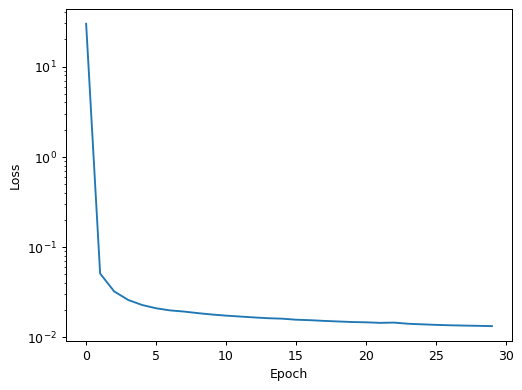

In [ ]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

The average error hasn't improved: it's now 11.8% compared with 9.5% (not a huge change, possibly just due to randomness), and the multiple groupings in the data haven't disappeared. This model isn't quite doing it yet.

tensor(0.1151)


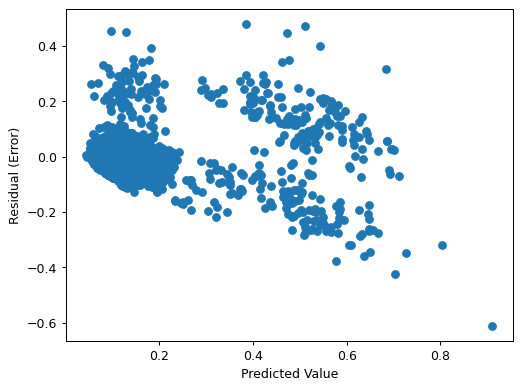

In [ ]:
plt.scatter(yhat, ys-yhat)
plt.xlabel("Predicted Value")
plt.ylabel("Residual (Error)")

print(torch.std(ys-yhat))

## More PyTorch + More Layers

What we've done so far is actually a a built-in feature of the PyTorch library. We create a `Module`, which is the PyTorch class that encapsulates initializing, predicting, and calculating gradients all in one:

In [ ]:
class NeuralNet (Module):
    # How to initialize the Module
    # The arguments after self are ours to choose.
    # Here, we'll make "layersN" be the number of nodes in each layer #N
    def __init__(self, inputs, M, R=20):

        self.w1 = torch.rand([M, R]).requires_grad_()
        self.b1 = torch.rand(R).requires_grad_()

        self.w2 = torch.rand(R).requires_grad_()
        self.b2 = torch.rand(1).requires_grad_()

    # This needs to be our predict function. Easy!
    def forward(self, xs):
        return one_layer(self.w1, self.b1, self.w2, self.b2, xs)


PyTorch lets us simplify this even further using pre-built layer and function objects:

In [ ]:
class NeuralNet (Module):

    # How to initialize the Module
    # The arguments after self are ours to choose.
    # Here, we'll make "hiddenN" be the number of nodes in hidden layer #N
    def __init__(self, M, hidden1, hidden2):

        # nn.Sequential means that each layer is done in order (a sequence)
        self.layers = nn.Sequential(
            nn.Linear(M, hidden1),      # Pre-defined "linear" layer
            nn.ReLU(),                  # Pre-defined ReLU activation
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 1)
        )

    # Return the calculation
    def forward(self):
        return self.layers(x)

## The fast.ai Tabular Learner

And of course, fast.ai already encapsulates all of this.

Let's take a look at its syntax:

In [ ]:
insurance = pd.read_csv("https://raw.githubusercontent.com/Greg-Hallenbeck/class-datasets/main/datasets/insurance.csv")
insurance.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


In [ ]:
from fastai.tabular.all import *

dataset = TabularPandas(insurance,                        # Pandas DataFrame
            procs=[Categorify,FillMissing,Normalize],     # Pre-processing we want to use
            cat_names = ['sex', 'smoker', 'region'],      # Categorical variables (will be "Categorify"ed) - encoding the categorical data... changing from categorys to numerical
            cont_names = ['age', 'bmi', 'children'],      # Continuous variables (will be "Normalize"d)
            y_names='charges',                            # Name of the y variable(s)
            splits=RandomSplitter()(range_of(insurance))) # How we'll split into training/validation sets

dls = dataset.dataloaders(bs=64) # Produce a DataLoaders from the dataset
                                 # (DataLoaders = one DataLoader for train and one for validation)


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=1.3182567358016968)

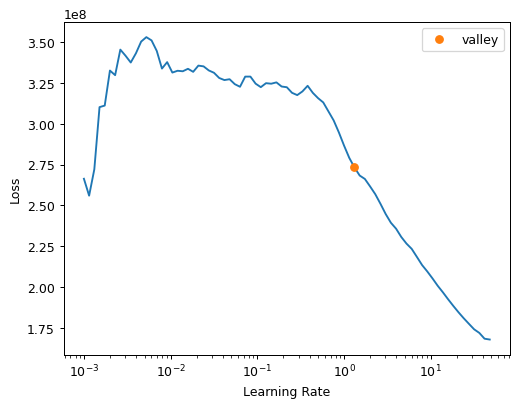

In [ ]:
# Create a tabular_learner with two hidden layers of 200 and 100 ReLU units (this is the default)
learn = tabular_learner(dls, layers=[200,100], metrics=rmse) #Creating a tabular learner (data we give to it, list of layers we want (2 layers, of 200 and 100 ReLu units), our loss function)

# A learning rate finder, like we made in class.
learn.lr_find(start_lr=1e-3, end_lr=1e3)

In [ ]:
# Use the found learning rate and train for a few epochs
learn = tabular_learner(dls, metrics=rmse, lr=2.3)
learn.fit_one_cycle(10) #number of epocs in the parenthesis

#Good training loss would go down throughout the more epocs you do, good valid loss  would do the same

#If the result isnt like this^^^ learning rate or number of epochs may need to change

The residual here is \$3567, which if we normalized it would be $\frac{3567}{64770} = 5.6$% compared with the ~$10$% we saw before. That's a good improvement! In addition, we no longer see any double-valued structure in the residuals, even if there are some large outliers. Excellent.

In addition, as fast.ai takes care of evaluating both the training and validation sets, let us return to issues of the quality of the fit and overfitting:

1. Take a look at the `_rmse` above: that is exactly what we've been measuring for the validation residuals, done for us. We aren't shown the training residuals because they are not important.
2. We also get the losses for both sets. In the last epoch, the losses are $35.2\times10^6$ and $13.0\times10^6$. In an overfit situation, the training loss would be much larger than the validation loss, and the gap would grow over time. Also, the validation loss would stop decreasing and start increasing. That isn't happening, so we haven't overfit at all here.

In [ ]:
# Produce residuals
yhat,y = learn.get_preds()

plt.scatter(yhat, yhat-y)
plt.xlabel("Predicted Value")
plt.ylabel("Residual (Error)")
print(torch.std(yhat-y))

## The Rest of the Owl

What we have built is a **neural network.** A neural network is a series of layers of **neurons**, each with some activation function. In our case, each neuron is one of these line fits that then gets fed into the ReLU function. With enough layers and neurons in each layer, you can approximate any output you desire. If you want **deep learning**, you just put lots of layers in your network. *That's it.*

To steal a joke and metaphor from the fast.ai notes, this feels a bit like the "Draw the rest of the fucking owl" meme. We've got these basics here, taking in data and feeding it through layers, and I'm telling you that all you need to get to ChatGPT is enough layers. And yeah, that is it.

<img src="https://i.kym-cdn.com/photos/images/original/000/572/078/d6d.jpg">

Everything that remains is details, but yes, there are a lot of details. Specifically:

* How do we get different kinds of questions (image and text classification) into a format that we can pass into a neural network?
* How can we modify the networks to be more efficient and get better predictions?


* New Loss FUnction

(pi is p sub i)

J = -(Sigma (i)) pi ln(phati)

the sigma portion sums over categories

pi is either a 0 or 1, probability of it being X as 0 or 100%

phati is the models prediction of what its looking at

As phati increase, ln phati increase, and -ln phati decrease

______

* New Activation for final layer
(soft max)

phati = (e^zi)/ (sigma e^zj)

zi can be anything from (-infinity, infinity)

e^zi can be (0, infinity)

phati can be (0,1)

and sigma(i) of Phati = 1

______

* New Human Readable Metric:

error rate = (# of incorrect labels)/(data size)


**This cant be used for our loss function, a graph plotted with this error rate
as the y and model quality on the X would result in a stair step graph, where every time the model gets something correct the error rate drops down vertically and then goes to a slope of 0 immediately after

**Its a bad loss function because the slope is always 0